# ICLR-Rebuttal, save other quantities using npy files

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import os
import json
import scipy

In [46]:
PATH = "E://P5_5_SFT_dynamics//results_visualize//npy_results"
# PATH_dpo = "E://P5_5_SFT_dynamics//results_visualize//npy_results//dpo"

OBSERVE_KEYS = ['chosen',
                 'chosen_initial', 'chosen_gptsemantic', 'chosen_gptformat', # 'chosen_selfr'
                 'rejected', 'rejected_gptsemantic', 'rejected_gptformat',
                 'irr_train', 'irr_test', 'irr_hum',
                 'random_permute', 'random_nonhum',
                ]

KEY_TO_TEXT = {'chosen':r'$y_u^+$',
               'chosen_initial': r'$y_\text{init}$',
               'chosen_gptsemantic':r'$y_\text{gpts}^+$',
               'chosen_gptformat':r'$y_\text{gptf}^+$',
               'rejected': r'$y_u^-$',
               'rejected_gptsemantic':r'$y_\text{gpts}^-$',
               'rejected_gptformat':r'$y_\text{gptf}^-$',
               'irr_train':r'$y_{j\neq u}^+$',
               'irr_test': r'$y_\text{test}^+$',
               'irr_hum':r'$y_\text{hum}$',
               'random_permute':r'$y_{urnd}^+$', 
               'random_nonhum': r'$y_{rnd}$',
               'DPO':'DPO'}

RESPONSE_LIST = ['chosen', 'argmax', 'except_argmax', 'chosen_A_o', 'p_e', 'energy',
                 'chosen_initial', 'chosen_gptsemantic', 'chosen_gptformat', # 'chosen_selfr'
                 'rejected', 'rejected_gptsemantic', 'rejected_gptformat',
                 'irr_train', 'irr_test', 'irr_hum',
                 'random_permute', 'random_nonhum',
                ]
RESPONSE_LIST_new = ['chosen', 'argmax', 'except_argmax', 
                     'chosen_A_o', 'p_e', 'energy',
                     'chosen_initial', 'chosen_initial_A_o', 'chosen_gptsemantic', 'chosen_gptsemantic_A_o', 
                     'chosen_gptformat', 'chosen_gptformat_A_o', 'rejected', 'rejected_A_o', 
                     'rejected_gptsemantic', 'rejected_gptsemantic_A_o',  'rejected_gptformat','rejected_gptformat_A_o',
                      'irr_train', 'irr_train_A_o', 'irr_test', 'irr_test_A_o', 'irr_hum','irr_hum_A_o',
                     'random_permute', 'random_permute_A_o','random_nonhum','random_nonhum_A_o']
print(len(RESPONSE_LIST), len(RESPONSE_LIST_new))
def smooth_path(origin_path, alpha=0.9, window=5, tp = 'ema'):
    if tp=='ema':
        origin_path_ = np.array(origin_path)
        smoothed_path = np.zeros_like(origin_path_)
        smoothed_path[0] = origin_path_[0]
        for i in range(1, origin_path_.shape[0]):
            smoothed_path[i] = smoothed_path[i-1]*alpha + origin_path_[i]*(1-alpha)
        return smoothed_path
    elif tp=='window':
        import copy
        seq_len = origin_path.shape[-1]
        smooth_path = copy.deepcopy(origin_path)
        for i in range(1,window,1):
            smooth_path[i]=origin_path[:i].mean()
        for i in range(window, seq_len-window, 1):
            smooth_path[i]=origin_path[i:i+window].mean()
        for i in range(seq_len-window, seq_len, 1):
            smooth_path[i]=origin_path[i:].mean()
        return smooth_path

17 28


In [3]:
def cal_ratio(npy_results, xo='chosen', metric='lbk'):
    if npy_results.shape[1] == 17:
        LIST = RESPONSE_LIST
        JAo = LIST.index('chosen_A_o')
        #print('====Old experiments===')
    elif npy_results.shape[1]==28:
        LIST = RESPONSE_LIST_new
        #print('====New experiments===')
        xo_a = xo + '_A_o'
        JAo = LIST.index(xo_a)
    JGu = LIST.index('p_e')
    Jo = LIST.index(xo)
    EPOCHS, L_KEYS, N_SAMPLES = npy_results.shape
    delta = npy_results[1:EPOCHS, Jo, :] - npy_results[0:EPOCHS-1, Jo, :]
    if metric=='lbk':
        return np.linalg.norm(delta,axis=-1)/np.sqrt(npy_results[1:EPOCHS, JAo, :].mean(-1))/npy_results[1:EPOCHS, JGu, :].mean(-1)
    elif metric=='signdelta':
        return delta.mean(-1)/np.sqrt(npy_results[1:EPOCHS, JAo, :].mean(-1))/npy_results[1:EPOCHS, JGu, :].mean(-1)
    

In [4]:
def draw_figure(results, metric='lbk', ax=None, x_label=None, y_label=None, title=None,legend=False):
    EPOCHS, L_KEYS, N_SAMPLES = results.shape
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(6,4))
    x_axis_n1 = np.arange(0, EPOCHS-1, 1)
    for i in range(len(OBSERVE_KEYS)):
        k = OBSERVE_KEYS[i]
        K_chosen = cal_ratio(results, xo=k,metric=metric)
        color = COLOR_MAP[k.split('_')[0]]
        label = KEY_TO_TEXT[k]
        alpha = ALPHA_LIST[i]
        ax.plot(x_axis_n1, smooth_path(K_chosen, ALPHA, WINDOW, TP), label=label, color=color, alpha=alpha)
    if legend:
        ax.legend(ncol=3,fontsize=12, loc='lower left')
    ax.grid(True)
    ax.set_xlim(-0, 48)
    if x_label is not None:
        ax.set_xlabel(x_label,fontsize=16)
    if y_label is not None:
        ax.set_ylabel(y_label,fontsize=16)
    if title is not None:
        ax.set_title(title,fontsize=16) 


def draw_figure_bar(results, metric='lbk', ax=None, x_label=None, y_label=None, title=None,legend=False):
    EPOCHS, L_KEYS, N_SAMPLES = results.shape
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(6,4))
    x_label = []
    y_mean, y_var = [],[]
    color_list = []
    for i in range(len(OBSERVE_KEYS)):
        k = OBSERVE_KEYS[i]
        K_chosen = cal_ratio(results_sft_chosen, xo=k,metric=metric)
        K_chosen = smooth_path(K_chosen, ALPHA, WINDOW, TP)
        color = COLOR_MAP[k.split('_')[0]]
        label = KEY_TO_TEXT[k]
        alpha = ALPHA_LIST[i]
        x_label.append(label)
        y_mean.append(K_chosen.sum())
        y_var.append(K_chosen.var())
        tmp_color = matplotlib.colors.to_rgba(COLOR_MAP[k.split('_')[0]])
        tmp_color = (tmp_color[0], tmp_color[1], tmp_color[2],ALPHA_LIST[i])
        color_list.append(tmp_color)
    ax.bar(x_label, y_mean, color=color_list)
    ax.errorbar(x_label, y_mean, yerr=y_var, fmt='.', color='Black', elinewidth=1,capthick=5,errorevery=1, alpha=0.5, ms=4, capsize = 1)   
    if legend:
        ax.legend(ncol=3,fontsize=12, loc='lower left')
    ax.tick_params(axis='x', labelrotation=60)
    #ax.grid(True)
    # if x_label is not None:
    #     ax.set_xlabel(x_label,fontsize=16)
    if y_label is not None:
        ax.set_ylabel(y_label,fontsize=16)
    if title is not None:
        ax.set_title(title,fontsize=16) 

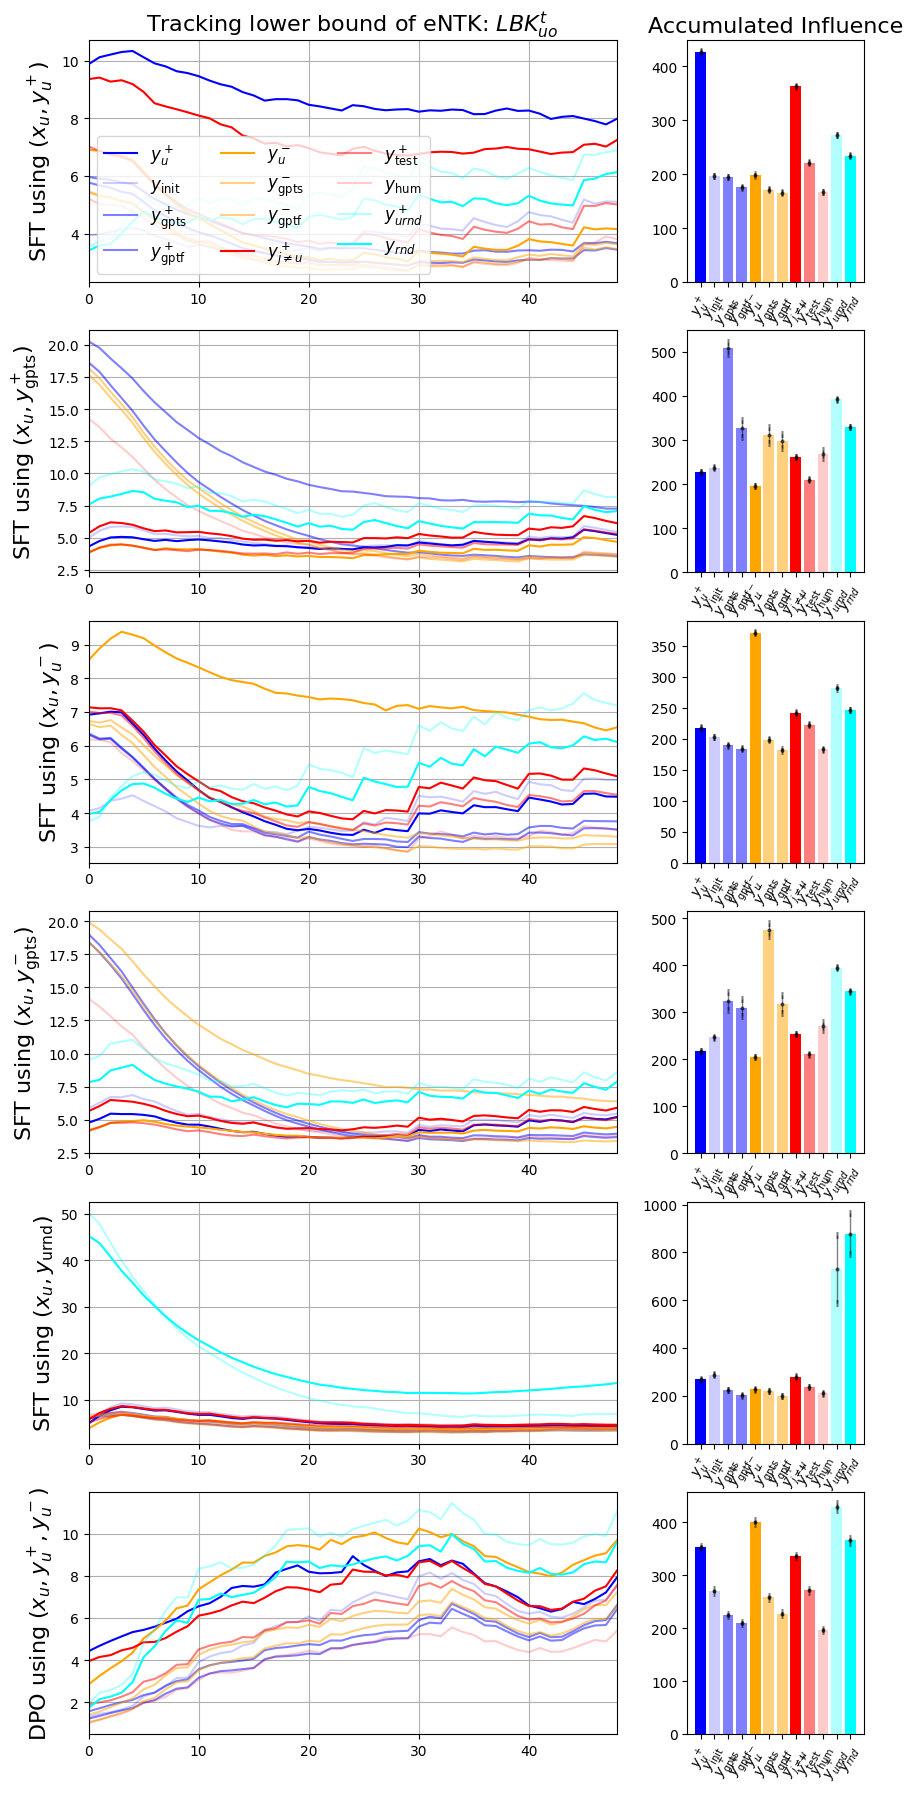

In [5]:
ALPHA = 0.9
WINDOW = 5
TP = 'ema'
METRIC = 'lbk'
COLOR_MAP = {'chosen':'blue', 'rejected':'orange', 'irr':'red', 'random':'cyan'}

KEY_LIST = [0, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
ALPHA_LIST = [1, 0.2, 0.5, 0.5, 1, 0.5, 0.5, 1, 0.5, 0.2, 0.3, 1]
FILE_LIST = ['sft/prob_pythia410m_supchosen_ep10/logp_npy_all_chosen.npy', 
             'sft/prob_pythia410m_supchosens_ep10/logp_npy_all_chosen_gptsemantic.npy',
             'sft/prob_pythia410m_suprejected_ep10/logp_npy_all_rejected.npy',
             'sft/prob_pythia410m_suprejecteds_ep10/logp_npy_all_reject_gptsemantic.npy',
             #'sft/prob_pythia410m_supirr_hum_ep10/logp_npy_all_irr_hum.npy',
             'sft/prob_pythia410m_suprandom_nonhum_ep10/logp_npy_all_random_nonhum.npy',
             'dpo/prob_pythia410m_dpo_ep10_chosen/logp_npy_all_chosen.npy',
             #'dpo/prob_pythia410m_dpo_ep10_rejected/logp_npy_all_rejected.npy' 
]
TITLE_LIST = [r'SFT using $(x_u, y_u^+)$', r'SFT using $(x_u, y_\text{gpts}^+)$', 
              r'SFT using $(x_u, y_u^-)$', 
              r'SFT using $(x_u, y_\text{gpts}^-)$', 
              #r'SFT using $(x_u, y_\text{rnd})$',
              r'SFT using $(x_u, y_\text{urnd})$',
              r'DPO using $(x_u, y_u^+, y_u^-)$',
              #r'DPO using $(x_u, y_\text{gpts}^+, y_u^-)$',             
]

fig, ax = plt.subplots(6,2,figsize=(10,22), gridspec_kw={'width_ratios': [3, 1]})

for i in range(6):
    # ------------ Left Panel
    if i==0:
        lgd_flg = True
        title_left = r'Tracking lower bound of eNTK: $LBK^t_{uo}$'
        title_right = r'Accumulated Influence'
    else:
        lgd_flg = False
        title_left = None
        title_right = None
    file_name = FILE_LIST[i]
    results_sft_chosen = np.load(os.path.join(PATH, file_name))
    draw_figure(results_sft_chosen, metric=METRIC, y_label = TITLE_LIST[i], ax=ax[i][0], title=title_left,legend=lgd_flg)
    # ------------ Right Panel    
    draw_figure_bar(results_sft_chosen, metric=METRIC, ax=ax[i][1], y_label=None, title=title_right,legend=False)

# plt.tight_layout()
# plt.savefig('LBK.pdf')

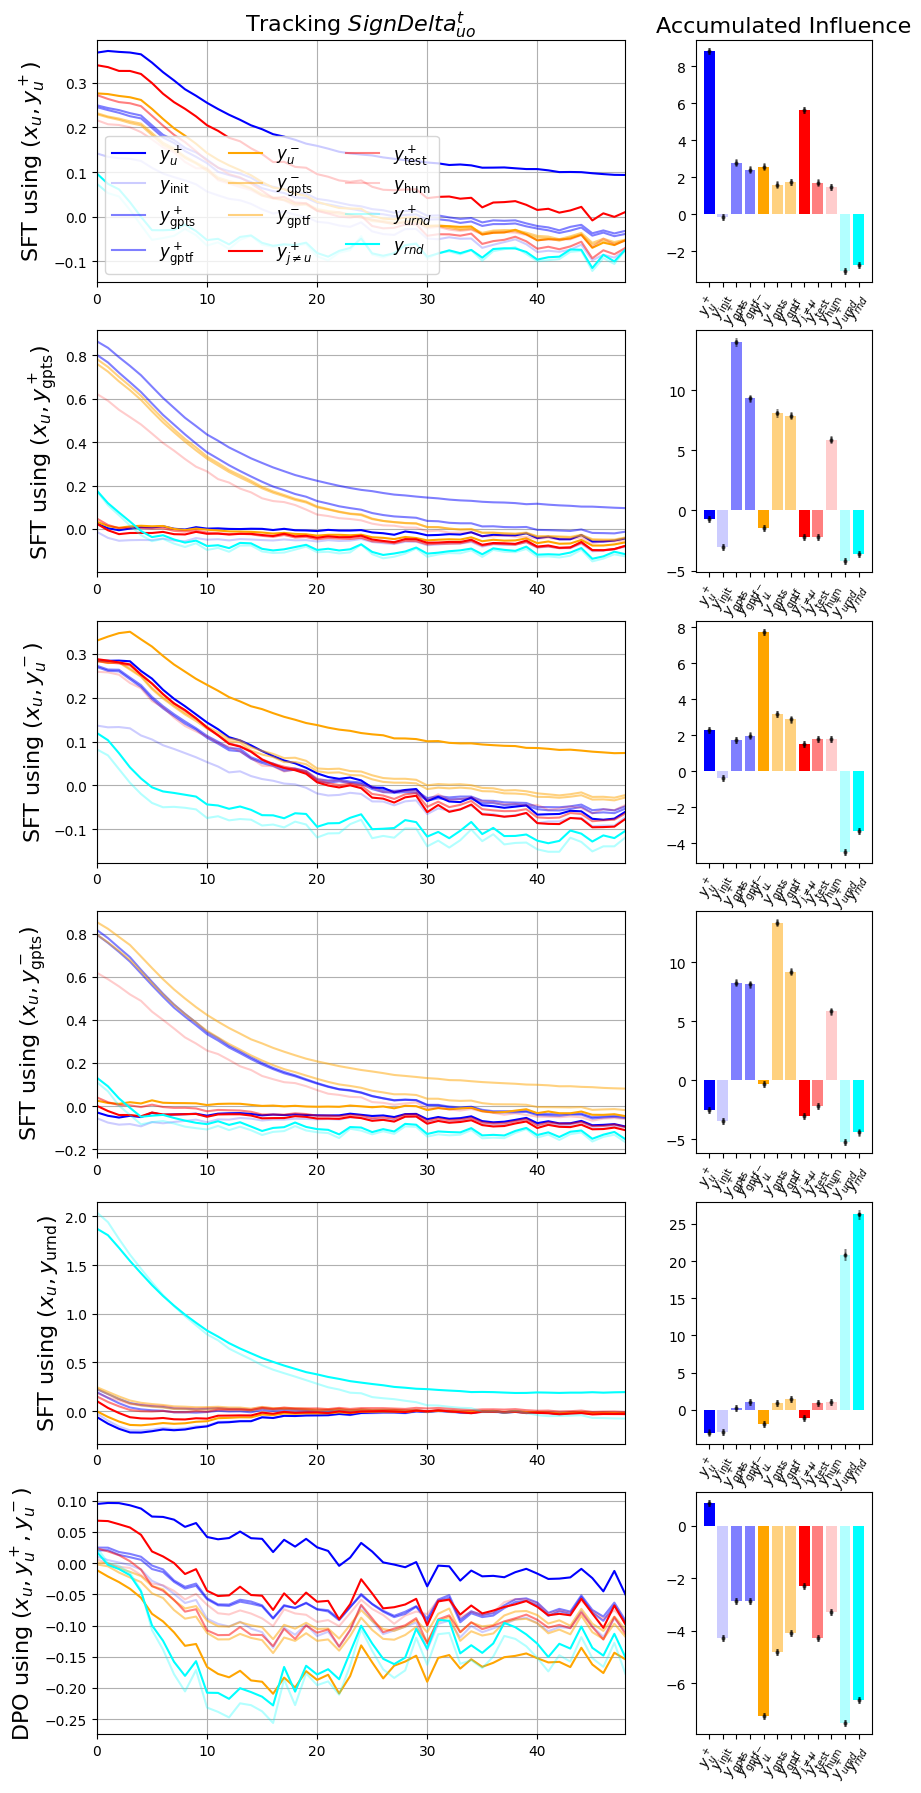

In [6]:
ALPHA = 0.9
WINDOW = 5
TP = 'ema'
METRIC = 'signdelta'
COLOR_MAP = {'chosen':'blue', 'rejected':'orange', 'irr':'red', 'random':'cyan'}

KEY_LIST = [0, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
ALPHA_LIST = [1, 0.2, 0.5, 0.5, 1, 0.5, 0.5, 1, 0.5, 0.2, 0.3, 1]
# FILE_LIST = ['prob_pythia410m_supchosen_ep10/logp_npy_all_chosen.npy', 
#             'prob_pythia410m_supchosens_ep10/logp_npy_all_chosen_gptsemantic.npy',
#              'prob_pythia410m_suprejected_ep10/logp_npy_all_rejected.npy',
#              #'prob_pythia410m_suprejected_ep10/logp_npy_all_rejected.npy' # not ready yet
#              'prob_pythia410m_supirr_hum_ep10/logp_npy_all_irr_hum.npy',
#              'prob_pythia410m_suprandom_nonhum_ep10/logp_npy_all_random_nonhum.npy'
# ]
# TITLE_LIST = [r'SFT using $(x_u, y_u^+)$', r'SFT using $(x_u, y_\text{gpts}^+)$', 
#               r'SFT using $(x_u, y_u^-)$', #r'SFT using $(x_u, y_\text{gpts}^-)$', 
#               r'SFT using $(x_u, y_\text{rnd})$',
#               r'SFT using $(x_u, y_\text{urnd})$'
# ]

fig, ax = plt.subplots(6,2,figsize=(10,22), gridspec_kw={'width_ratios': [3, 1]})

for i in range(6):
    # ------------ Left Panel
    if i==0:
        lgd_flg = True
        title_left = r'Tracking $SignDelta^t_{uo}$'
        title_right = r'Accumulated Influence'
    else:
        lgd_flg = False
        title_left = None
        title_right = None
    file_name = FILE_LIST[i]
    results_sft_chosen = np.load(os.path.join(PATH, file_name))
    draw_figure(results_sft_chosen, metric=METRIC, y_label = TITLE_LIST[i], ax=ax[i][0], title=title_left,legend=lgd_flg)
    # ------------ Right Panel    
    draw_figure_bar(results_sft_chosen, metric=METRIC, ax=ax[i][1], y_label=None, title=title_right,legend=False)

# plt.tight_layout()
# plt.savefig('SignDelta.pdf')

In [91]:
# Draw the heatmap
FILE_LIST = ['sft/prob_pythia410m_supchosen_ep10/logp_npy_all_chosen.npy', 
             'sft/prob_pythia410m_suprejected_ep10/logp_npy_all_rejected.npy',
             'sft/prob_pythia410m_supchosens_ep10/logp_npy_all_chosen_gptsemantic.npy',
             'sft/prob_pythia410m_suprejecteds_ep10/logp_npy_all_reject_gptsemantic.npy',
             'sft/prob_pythia410m_supirr_hum_ep10/logp_npy_all_irr_hum.npy',
             'sft/prob_pythia410m_suprandom_nonhum_ep10/logp_npy_all_random_nonhum.npy',
             'dpo/prob_pythia410m_dpo_ep10_chosen/logp_npy_all_chosen.npy',
             #'dpo/prob_pythia410m_dpo_ep10_rejected/logp_npy_all_rejected.npy' 
]



X_KEYS = ['chosen', 'rejected', 'chosen_gptsemantic', 'rejected_gptsemantic', 'irr_hum', 'random_nonhum', 'DPO']

Y_KEYS = ['chosen', 'rejected', 'chosen_gptsemantic', 'rejected_gptsemantic', 'irr_hum', 
          'irr_train', 'irr_test','random_nonhum']

x_labels = []
for i in range(len(X_KEYS)):
    x_labels.append(KEY_TO_TEXT[X_KEYS[i]])
y_labels = []
for i in range(len(Y_KEYS)):
    y_labels.append(KEY_TO_TEXT[Y_KEYS[i]])

tmp_res = np.zeros((len(Y_KEYS), len(FILE_LIST)))

for i in range(len(FILE_LIST)):
    file_name = FILE_LIST[i]
    y_mean = []
    results_sft_chosen = np.load(os.path.join(PATH, file_name))
    for j in range(len(Y_KEYS)):
        k = Y_KEYS[j]
        K_chosen = cal_ratio(results_sft_chosen, xo=k,metric='signdelta')
        K_chosen = smooth_path(K_chosen, ALPHA, WINDOW, TP)
        y_mean.append(K_chosen.sum())
        tmp_res[j, i] = K_chosen.sum()

for i in range(len(FILE_LIST)):
    tmp_res[:,i] = tmp_res[:,i] / (tmp_res[:,i].max()-tmp_res[:,i].min())

np.save('tmp_res.npy', tmp_res)

In [94]:
y_labels 

['$y_u^+$',
 '$y_u^-$',
 '$y_\\text{gpts}^+$',
 '$y_\\text{gpts}^-$',
 '$y_\\text{hum}$',
 '$y_{j\\neq u}^+$',
 '$y_\\text{test}^+$',
 '$y_{rnd}$']

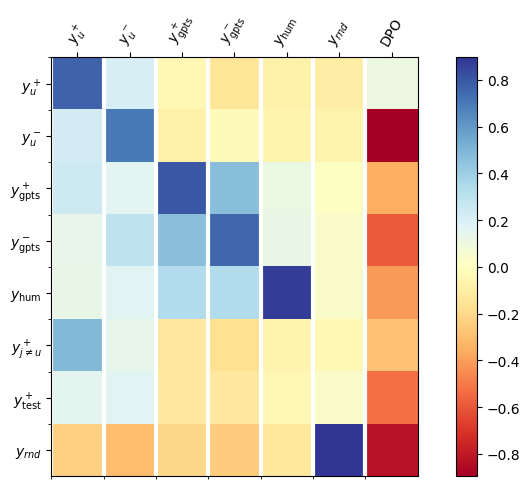

In [92]:
tmp_res = np.load('tmp_res.npy')
import matplotlib.colors as colors
import matplotlib.patches as patches
fig, ax = plt.subplots(1,1,figsize=(8,5))
pc = ax.imshow(tmp_res,norm = colors.CenteredNorm(), cmap='RdYlBu')
plt.colorbar(pc)
ax.tick_params(axis='x', labelrotation=60)
ax.set_xticks(np.arange(len(x_labels))-.5, minor=True)
ax.set_xticks(np.arange(len(x_labels)), labels=x_labels)
ax.set_yticks(np.arange(len(y_labels))-.5, minor=True)
ax.set_yticks(np.arange(len(y_labels)), labels=y_labels)
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax.grid(which="minor", axis='x', color="w", linestyle='-', linewidth=3)

# rect = patches.Rectangle((1.45, 1.45), 3.2, 3.2, linewidth=3, edgecolor='r', facecolor='none')
# ax.add_patch(rect)
plt.tight_layout()
plt.savefig('heat_map_SFT.pdf')

### Draw figures showing |A_o|, energy, p-e, etc.

In [327]:
def get_fit_line(y, L_all = 50):
    from scipy import interpolate
    L = y.shape[0]
    x = np.arange(0, L, 1)
    x_all = np.arange(0,L_all,1)
    def func(x, a, b):
        #return a * np.exp(-b * x) + c
        return a*x+b
    popt, pcov = curve_fit(func, x, y)
    y_all = func(x_all,*popt)
    return y_all

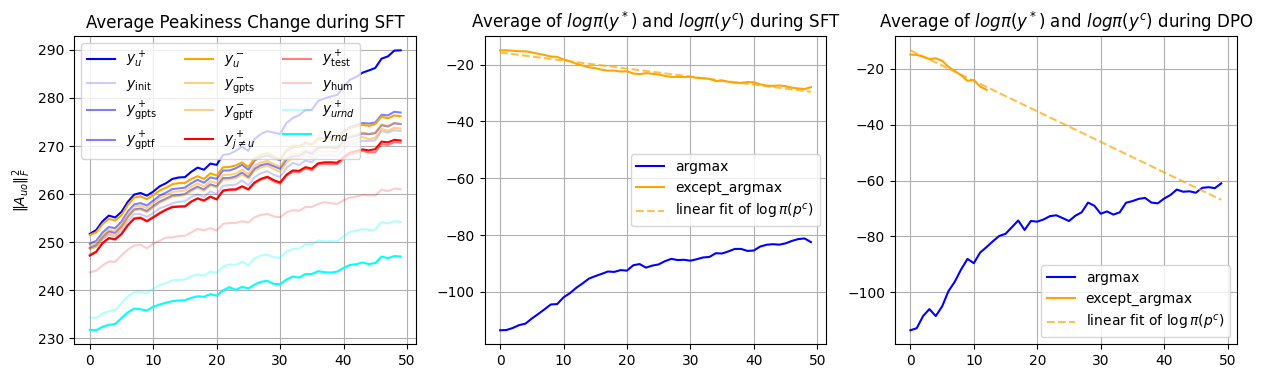

In [362]:
AO_LIST = ['chosen_A_o','chosen_initial_A_o', 'chosen_gptsemantic_A_o','chosen_gptformat_A_o', 
           'rejected_A_o', 'rejected_gptsemantic_A_o', 'rejected_gptformat_A_o', 
           'irr_train_A_o', 'irr_test_A_o', 'irr_hum_A_o', 'random_permute_A_o','random_nonhum_A_o']
LABEL_LIST = [r'$y_u^+$',r'$y_\text{init}$', r'$y_\text{gpts}^+$',r'$y_\text{gptf}^+$', 
            r'$y_u^-$', r'$y_\text{gpts}^-$', r'$y_\text{gptf}^-$',
            r'$y_{j\neq u}^+$', r'$y_\text{test}^+$', r'$y_\text{hum}$', r'$y_{urnd}^+$', r'$y_{rnd}$']
fig, ax = plt.subplots(1,3,figsize=(15,4))

file_name='sft/prob_pythia410m_supchosen_ep10/logp_npy_all_chosen.npy'
results_sft_chosen = np.load(os.path.join(PATH, file_name))
if results_sft_chosen.shape[1] == 17:
    LIST = RESPONSE_LIST
elif results_sft_chosen.shape[1]==28:
    LIST = RESPONSE_LIST_new
        
for i in range(len(AO_LIST)):
    k = AO_LIST[i]
    color = COLOR_MAP[k.split('_')[0]]
    idx = LIST.index(k)
    label = LABEL_LIST[i]
    alpha = ALPHA_LIST[i]
    ax[0].plot(results_sft_chosen[:, idx,:].mean(-1), label=label, color=color, alpha=alpha)
ax[0].set_title('Average Peakiness Change during SFT')
ax[0].set_ylabel(r'$\|A_{uo}\|_F^2$')
ax[0].grid()
ax[0].legend(ncol=3)

file_name='sft/prob_pythia410m_supchosen_ep20/logp_npy_all_chosen.npy'
file_name='sft/prob_pythia410m_supchosen/logp_npy_all_chosen.npy'
results_sft_chosen = np.load(os.path.join(PATH, file_name))
# ----------- Compare Argmax and Expect Argmax
argmax_idx = LIST.index('argmax')
exp_idx = LIST.index('except_argmax')
ax[1].plot(results_sft_chosen[:, argmax_idx,:].mean(-1),color='blue', label='argmax')
ax[1].plot(results_sft_chosen[:, exp_idx,:].mean(-1), label='except_argmax',color='orange')
x_all = np.arange(0,50,1)
y_fit = get_fit_line(results_sft_chosen[:, exp_idx,:].mean(-1), 50)
ax[1].plot(x_all,y_fit, color='orange', linestyle='dashed',alpha=0.7, label=r'linear fit of $\log\pi(p^c)$')
ax[1].set_title(r'Average of $log\pi(y^*)$ and $log\pi(y^c)$ during SFT')
ax[1].legend()
ax[1].grid()


# for i in range(len(FILE_LIST)-2):
#     file_name=FILE_LIST[i]
#     results_sft_chosen = np.load(os.path.join(PATH, file_name))
    
#     #color = COLOR_MAP[k.split('_')[0]]
#     idx = LIST.index('energy')
#     label = LABEL_LIST[i]
#     alpha = ALPHA_LIST[i]
#     ax[3].plot(results_sft_chosen[:, idx,:].mean(-1)*0.5, label=label, color=color, alpha=alpha)
# ax[3].set_title('Average Peakiness Change during SFT')
# ax[3].set_ylabel(r'$\|A_{uo}\|_F^2$')
# ax[3].grid()
# ax[3].legend(ncol=3)



file_name='dpo/prob_pythia410m_dpo_ep10_chosen/logp_npy_all_chosen.npy'
#file_name='dpo/logp_npy_all_chosen.npy'
results_sft_chosen = np.load(os.path.join(PATH, file_name))
# ----------- Compare Argmax and Expect Argmax
argmax_idx = LIST.index('argmax')
exp_idx = LIST.index('except_argmax')
ax[2].plot(results_sft_chosen[:, argmax_idx,:].mean(-1),color='blue', label='argmax')
ax[2].plot(results_sft_chosen[:, exp_idx,:].mean(-1), label='except_argmax',color='orange')
x_all = np.arange(0,50,1)
y_fit = get_fit_line(results_sft_chosen[:, exp_idx,:].mean(-1)[:12], 50)
ax[2].plot(x_all,y_all, color='orange', linestyle='dashed',alpha=0.7, label=r'linear fit of $\log\pi(p^c)$')
ax[2].set_title(r'Average of $log\pi(y^*)$ and $log\pi(y^c)$ during DPO')
ax[2].legend()
ax[2].grid()

plt.savefig('other_metrics.pdf')